'TEST_train_data_final_with_fault_counts_past_year_full_month.csv' 파일 (총 782행)을 성공적으로 불러왔습니다.

총 782개의 데이터로 모델링을 시작합니다.
사용된 특성(Features): ['magnitude', 'depth', 'is_ocean', 'is_steep_slope', 'horizontal_count_1y_full', 'vertical_count_1y_full']
훈련 데이터: 625개 / 테스트 데이터: 157개

--- 1. 로지스틱 회귀 모델 학습 중... ---

--- 2. 모델 평가 (테스트 데이터) ---
모델 정확도(Accuracy): 59.87%

[분류 리포트 (Classification Report)]
                precision    recall  f1-score   support

No Tsunami (0)       0.69      0.61      0.65        96
   Tsunami (1)       0.49      0.57      0.53        61

      accuracy                           0.60       157
     macro avg       0.59      0.59      0.59       157
  weighted avg       0.61      0.60      0.60       157


[혼동 행렬 (Confusion Matrix)]
[[59 37]
 [26 35]]
혼동 행렬을 'confusion_matrix.png' 파일로 저장했습니다.

--- 3. 최종 변수 영향력 (모델 계수) ---

훈련된 모델의 최종 변수 영향력(중요도):
| Feature                  | Coefficient (Log-Odds)   | Absolute_Impact   |
|:-------------------------|:--------------------

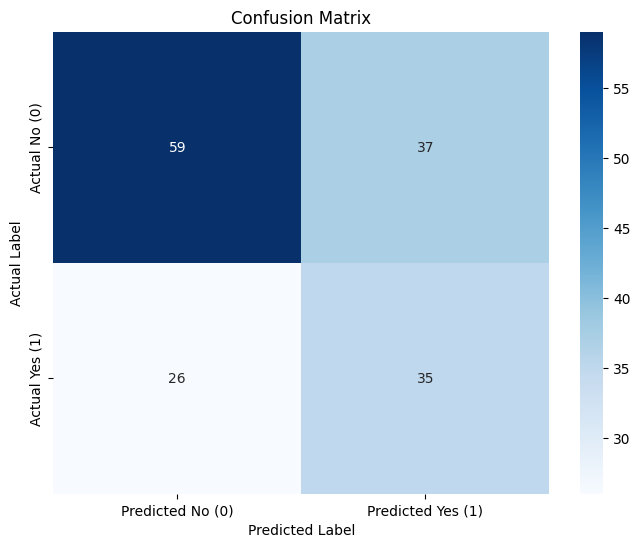

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. 데이터 불러오기 ---
file_name = 'TEST_train_data_final_with_fault_counts_past_year_full_month.csv'
try:
    df = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"오류: '{file_name}' 파일을 찾을 수 없습니다.")
    exit()

print(f"'{file_name}' 파일 (총 {len(df)}행)을 성공적으로 불러왔습니다.")

# --- 1. 전처리 ---
# 'is_ocean'과 'is_steep_slope'을 1/0으로 변환합니다.
if 'is_ocean' in df.columns:
    df['is_ocean'] = df['is_ocean'].apply(lambda x: 1 if (x == True or str(x).lower() == 'true') else 0)
if 'is_steep_slope' in df.columns:
    df['is_steep_slope'] = df['is_steep_slope'].apply(lambda x: 1 if (x == True or str(x).lower() == 'true') else 0)

# --- 2. 특성(X)과 타겟(y) 정의 ---
# 우리가 최종적으로 만든 6개의 핵심 변수를 사용합니다.
feature_names = [
    'magnitude',
    'depth',
    'is_ocean',
    'is_steep_slope',
    'horizontal_count_1y_full',
    'vertical_count_1y_full'
]

# 결측치가 있는 행을 제거
df_model = df[feature_names + ['tsunami']].dropna()

X = df_model[feature_names]
y = df_model['tsunami']

print(f"\n총 {len(df_model)}개의 데이터로 모델링을 시작합니다.")
print(f"사용된 특성(Features): {feature_names}")

# --- 3. 훈련 / 테스트 데이터 분리 ---
# 데이터를 훈련용(80%)과 테스트용(20%)으로 분리합니다.
# stratify=y : 훈련/테스트셋의 쓰나미(0, 1) 비율을 원본과 동일하게 유지합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20%를 테스트용으로 사용
    random_state=42,  # 결과를 재현할 수 있도록 고정
    stratify=y        # 쓰나미 비율(0/1)을 유지
)

print(f"훈련 데이터: {len(X_train)}개 / 테스트 데이터: {len(X_test)}개")

# --- 4. 데이터 스케일링 ---
# 'magnitude'와 'is_ocean'처럼 단위가 다른 변수들의 영향력을 통일시킵니다.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # 훈련 데이터로 '기준'을 학습
X_test_scaled = scaler.transform(X_test)     # 학습된 '기준'으로 테스트 데이터 변환

# --- 5. 로지스틱 회귀 모델 학습 ---
print("\n--- 1. 로지스틱 회귀 모델 학습 중... ---")
# class_weight='balanced' : 쓰나미가 발생(1)한 경우가 드물기 때문에,
#                          모델이 1을 더 중요하게(가중치) 학습하도록 설정
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# --- 6. 모델 평가 ---
print("\n--- 2. 모델 평가 (테스트 데이터) ---")
# 학습이 끝난 모델로 '처음 보는' 테스트 데이터(X_test_scaled)를 예측
y_pred = model.predict(X_test_scaled)

# 6-1. 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"모델 정확도(Accuracy): {accuracy * 100:.2f}%")

# 6-2. 분류 리포트 (정밀도, 재현율)
print("\n[분류 리포트 (Classification Report)]")
# precision(정밀도): 모델이 "쓰나미=1"이라고 예측한 것 중, '진짜 1'의 비율
# recall(재현율): '진짜 1'인 모든 쓰나미 중, 모델이 '1'이라고 맞춘 비율 (가장 중요!)
print(classification_report(y_test, y_pred, target_names=['No Tsunami (0)', 'Tsunami (1)']))

# 6-3. 혼동 행렬 (Confusion Matrix)
print("\n[혼동 행렬 (Confusion Matrix)]")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No (0)', 'Predicted Yes (1)'],
            yticklabels=['Actual No (0)', 'Actual Yes (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
print("혼동 행렬을 'confusion_matrix.png' 파일로 저장했습니다.")

# --- 7. 최종 변수 영향력 분석 (참고) ---
# 이 모델이 무엇을 중요하게 학습했는지 확인
print("\n--- 3. 최종 변수 영향력 (모델 계수) ---")
coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient (Log-Odds)': coefficients
})
coef_df['Absolute_Impact'] = np.abs(coef_df['Coefficient (Log-Odds)'])
coef_df = coef_df.sort_values(by='Absolute_Impact', ascending=False)

print("\n훈련된 모델의 최종 변수 영향력(중요도):")
print(coef_df.to_markdown(index=False, numalign="left", stralign="left"))

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib # ★★★ 모델 저장을 위해 import

# --- 0. 데이터 불러오기 ---
file_name = 'TEST_train_data_final_with_fault_counts_past_year_full_month.csv'
try:
    df = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"오류: '{file_name}' 파일을 찾을 수 없습니다.")
    exit()

print(f"'{file_name}' 파일 (총 {len(df)}행)을 성공적으로 불러왔습니다.")

# --- 1. 전처리 ---
if 'is_ocean' in df.columns:
    df['is_ocean'] = df['is_ocean'].apply(lambda x: 1 if (x == True or str(x).lower() == 'true') else 0)
if 'is_steep_slope' in df.columns:
    df['is_steep_slope'] = df['is_steep_slope'].apply(lambda x: 1 if (x == True or str(x).lower() == 'true') else 0)

# --- 2. 특성(X)과 타겟(y) 정의 ---
feature_names = [
    'magnitude',
    'depth',
    'is_ocean',
    'is_steep_slope',
    'horizontal_count_1y_full',
    'vertical_count_1y_full'
]
df_model = df[feature_names + ['tsunami']].dropna()
X = df_model[feature_names]
y = df_model['tsunami']

# --- 3. 훈련 / 테스트 데이터 분리 ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. 데이터 스케일링 ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 5. 로지스틱 회귀 모델 학습 ---
print("\n--- 1. 로지스틱 회귀 모델 학습 중... ---")
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# --- 6. 모델 평가 ---
print("\n--- 2. 모델 평가 (테스트 데이터) ---")
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"모델 정확도(Accuracy): {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


# --- 7. ★★★ 모델 파일로 저장 (핵심) ★★★ ---
print("\n--- 3. 훈련된 모델과 스케일러 저장 중... ---")

# 7-1. 모델 저장
model_filename = 'tsunami_model.joblib'
joblib.dump(model, model_filename)
print(f"모델을 '{model_filename}' 파일로 저장했습니다.")

# 7-2. (매우 중요) 스케일러 저장
# 서비스에서 새로운 데이터도 '훈련 때와 똑같이' 스케일링해야 합니다.
scaler_filename = 'tsunami_scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"스케일러를 '{scaler_filename}' 파일로 저장했습니다.")

'TEST_train_data_final_with_fault_counts_past_year_full_month.csv' 파일 (총 782행)을 성공적으로 불러왔습니다.

--- 1. 로지스틱 회귀 모델 학습 중... ---

--- 2. 모델 평가 (테스트 데이터) ---
모델 정확도(Accuracy): 59.87%
              precision    recall  f1-score   support

           0       0.69      0.61      0.65        96
           1       0.49      0.57      0.53        61

    accuracy                           0.60       157
   macro avg       0.59      0.59      0.59       157
weighted avg       0.61      0.60      0.60       157


--- 3. 훈련된 모델과 스케일러 저장 중... ---
모델을 'tsunami_model.joblib' 파일로 저장했습니다.
스케일러를 'tsunami_scaler.joblib' 파일로 저장했습니다.


In [3]:
import joblib
import numpy as np

# --- 1. 저장된 모델과 스케일러 불러오기 ---
try:
    model = joblib.load('tsunami_model.joblib')
    scaler = joblib.load('tsunami_scaler.joblib')
    print("모델과 스케일러 로드 성공!")
except FileNotFoundError:
    print("오류: 'tsunami_model.joblib' 또는 'tsunami_scaler.joblib' 파일을 찾을 수 없습니다.")
    print("먼저 모델 저장 스크립트를 실행하세요.")
    exit()

# --- 2. 새로운 지진 데이터 (예시) ---
# 서비스에 (M6.9, 깊이 25km, 바다, 급경사, 수평1, 수직1) 데이터가 들어왔다고 가정
# 6개 특성 순서: ['magnitude', 'depth', 'is_ocean', 'is_steep_slope',
#                 'horizontal_count_1y_full', 'vertical_count_1y_full']

new_quake_data = np.array([
    [6.9, 25.0, 1, 1, 1, 1]
])

print(f"\n새로운 지진 데이터: {new_quake_data}")

# --- 3. (필수) 훈련 때 사용한 스케일러로 새 데이터 변환 ---
new_quake_data_scaled = scaler.transform(new_quake_data)
print(f"스케일링된 데이터: {new_quake_data_scaled}")

# --- 4. 쓰나미 예측 ---
prediction = model.predict(new_quake_data_scaled)
prediction_proba = model.predict_proba(new_quake_data_scaled)

# --- 5. 결과 출력 ---
print("\n--- 예측 결과 ---")
if prediction[0] == 1:
    print(f"🚨 쓰나미 발생 확률: {prediction_proba[0][1] * 100:.2f}% 🚨")
    print("  -> 예측: [1] (쓰나미 발생)")
else:
    print(f"✅ 쓰나미 발생 확률: {prediction_proba[0][1] * 100:.2f}% ✅")
    print("  -> 예측: [0] (쓰나미 미발생)")

모델과 스케일러 로드 성공!

새로운 지진 데이터: [[ 6.9 25.   1.   1.   1.   1. ]]
스케일링된 데이터: [[-0.09989109 -0.35386198  0.63848074  1.13182238  0.07923375 -0.45962336]]

--- 예측 결과 ---
🚨 쓰나미 발생 확률: 60.70% 🚨
  -> 예측: [1] (쓰나미 발생)


C:\Python1\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
